# Displaying the stacked map of polarisations

In [3]:
import pandas as pd
import healpy as hp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Importing the stacked data for no lensing

In [4]:
shape = "Output/nolens_shape.txt"
with open(shape, "r") as f:
    loaded_shape = tuple(map(int, f.read().strip().split(",")))

# Load the DataFrame from the CSV file
csv_filename = "Output/nolens.csv"
loaded_df = pd.read_csv(csv_filename)

# Convert the DataFrame back to a numpy array
loaded_flattened_array = loaded_df.values

# Reshape the array back to its original shape
nolens = loaded_flattened_array.reshape(loaded_shape)

## Importing the stacked data for lensed data

In [5]:
# Load the DataFrame from the CSV file
csv_filename = "Output/lensed.csv"
loaded_df = pd.read_csv(csv_filename)

# Convert the DataFrame back to a numpy array
loaded_flattened_array = loaded_df.values

# Reshape the array back to its original shape
lensed = loaded_flattened_array.reshape(loaded_shape)

## plots for temperature

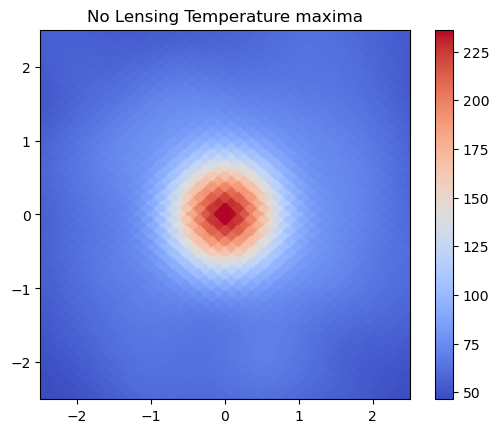

In [6]:
# no lens
plt.imshow(
    nolens[0, 0, :, :],
    extent=(-2.5, 2.5, -2.5, 2.5),
    origin="lower",
    cmap="coolwarm",
)
plt.colorbar()
plt.title("No Lensing Temperature maxima")
plt.show()

## plots for Q

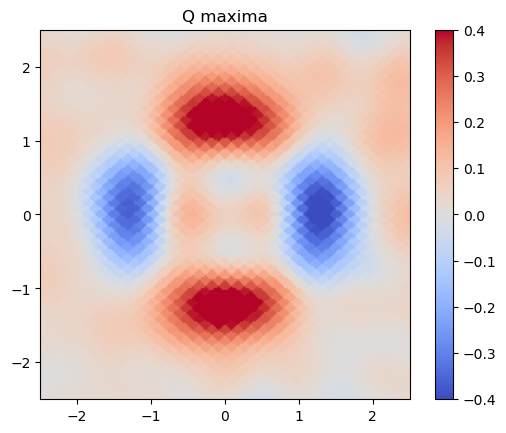

In [7]:
# no lens
plt.imshow(
    nolens[0, 1, :, :],
    extent=(-2.5, 2.5, -2.5, 2.5),
    origin="lower",
    cmap="coolwarm",
    vmin=-0.4,
    vmax=0.4,
)
plt.colorbar()
plt.title("Q maxima")
plt.show()

## U plot

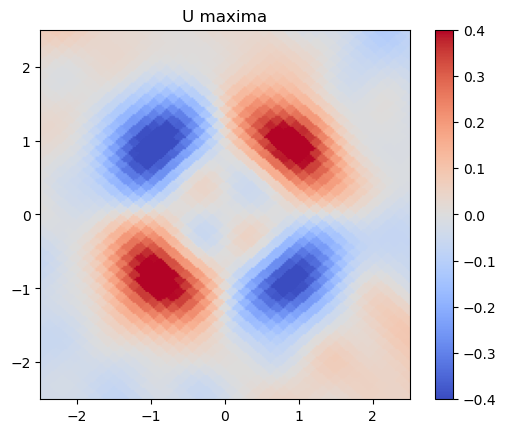

In [8]:
# no lens
plt.imshow(
    nolens[0, 2, :, :],
    extent=(-2.5, 2.5, -2.5, 2.5),
    origin="lower",
    cmap="coolwarm",
    vmin=-0.4,
    vmax=0.4,
)
plt.colorbar()
plt.title("U maxima")
plt.show()

## Qr map

In [9]:
# generating array of vectors
def pol_vec(Q, U):
    phi = 0.5 * np.arctan2(-U, Q)
    P = np.sqrt(Q**2 + U**2)
    return phi, P


# Function to create inputs for vector map
def vectormap(step, Q, U):
    sample_indices = np.ix_(np.arange(0, 200, step), np.arange(0, 200, step))
    phi, P = pol_vec(Q[sample_indices], U[sample_indices])
    x, y = np.meshgrid(
        np.linspace(-2.5, 2.5, Q.shape[1] // step),
        np.linspace(-2.5, 2.5, Q.shape[0] // step),
    )
    u = P * np.cos(phi)
    v = P * np.sin(phi)
    return x, y, u, v

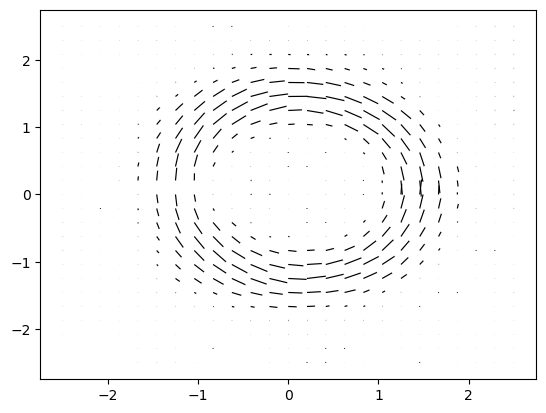

In [10]:
# max no lens
x, y, u, v = vectormap(8, nolens[0, 1, :, :], nolens[0, 2, :, :])
plt.quiver(x, y, u, v, scale=10, headwidth=0, color="black")
plt.show()

In [11]:
# Function to create inputs for vector map
def vectormap(step, Q, U):
    sample_indices = np.ix_(np.arange(0, 200, step), np.arange(0, 200, step))
    phi, P = pol_vec(Q[sample_indices], U[sample_indices])
    x, y = np.meshgrid(
        np.linspace(-2.5, 2.5, Q.shape[1] // step),
        np.linspace(-2.5, 2.5, Q.shape[0] // step),
    )
    u = P * np.cos(phi)
    v = P * np.sin(phi)
    return x, y, u, v


# Compute vectormap data once
def compute_vectormaps(average, step):
    x_dict, y_dict, u_dict, v_dict = {}, {}, {}, {}
    for minmax in range(2):
        x, y, ur, vr = vectormap(
            step,
            average[minmax, 1, :, :],
            average[minmax, 2, :, :],
        )
        x_dict[minmax] = x
        y_dict[minmax] = y
        u_dict[minmax] = ur
        v_dict[minmax] = vr

    return x_dict, y_dict, u_dict, v_dict


# Function for plotting
def plot_param(ax, im_data, x, y, u, v, params, minmax, quiver_required):
    im = ax.imshow(
        im_data, extent=(-2.5, 2.5, -2.5, 2.5), origin="lower", cmap="coolwarm"
    )
    ax.grid()
    ax.set_xlabel("Degrees")
    ax.set_ylabel("Degrees")
    ax.set_title(f"Average of the {'maxima' if minmax == 0 else 'minima'} of {params}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="20%", pad=0.05)
    plt.colorbar(im, cax=cax, format="%.2f")

    if quiver_required:
        ax.quiver(x, y, u, v, scale=10, headwidth=0, color="black")

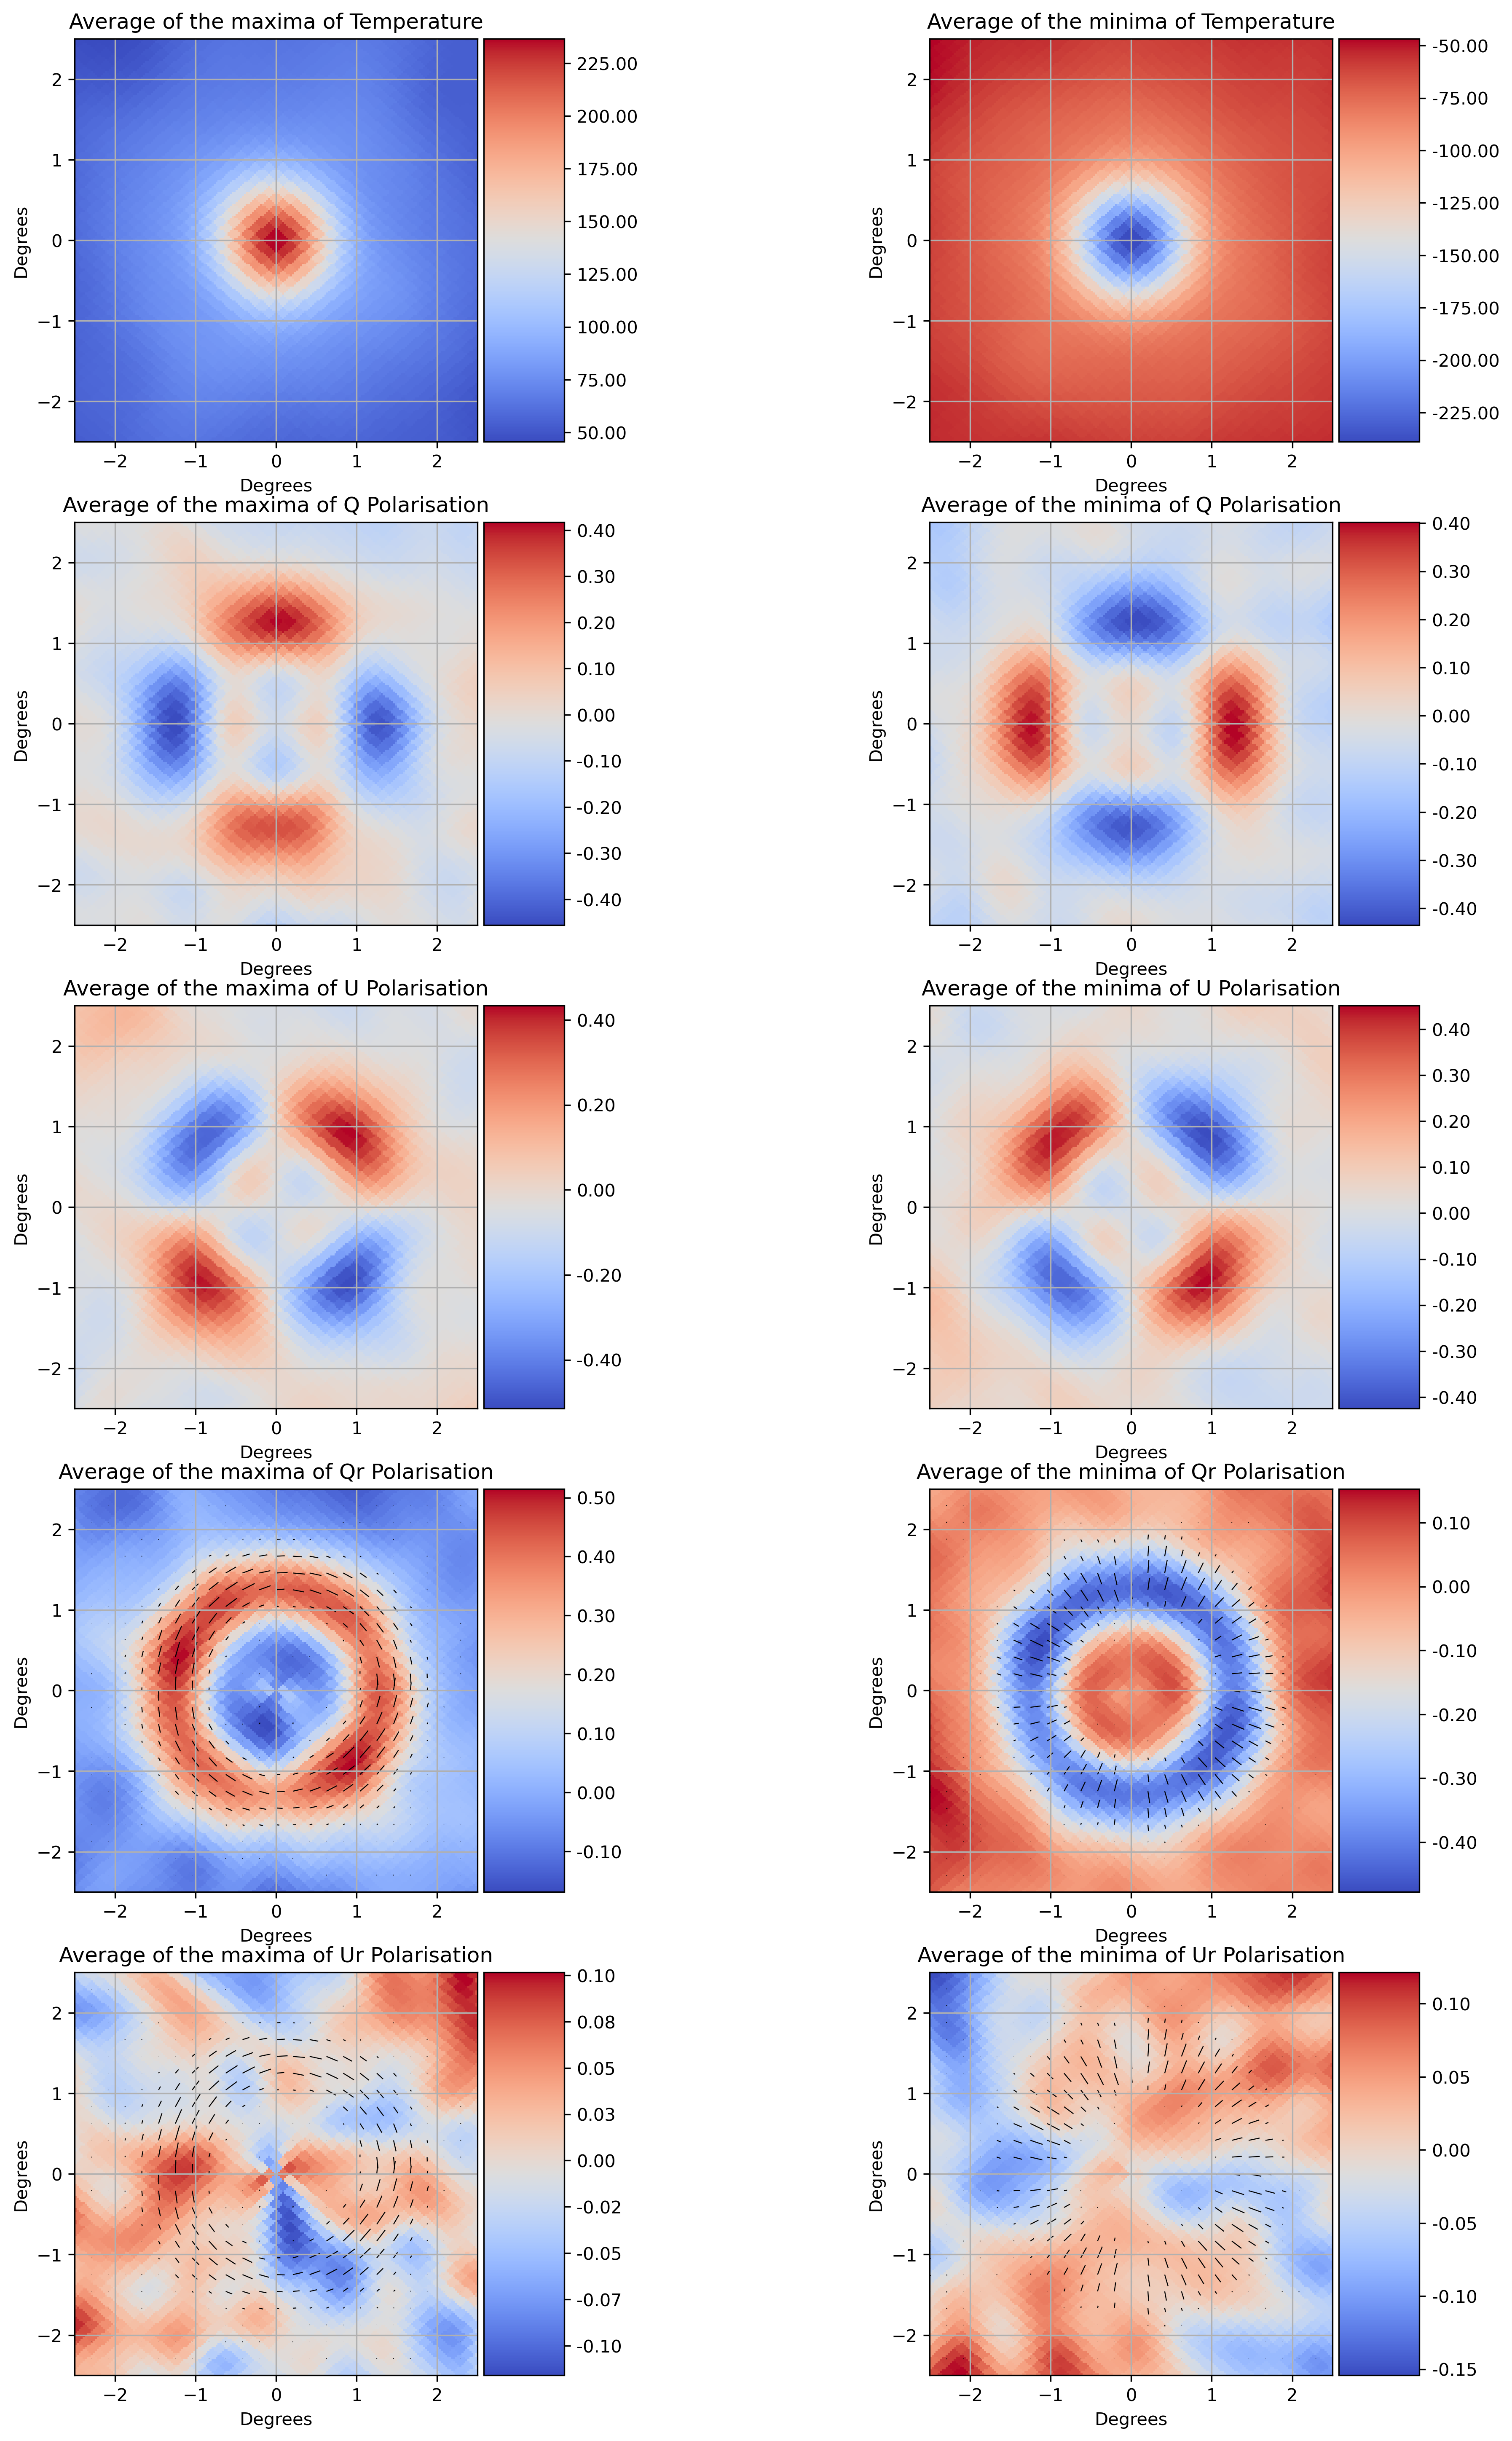

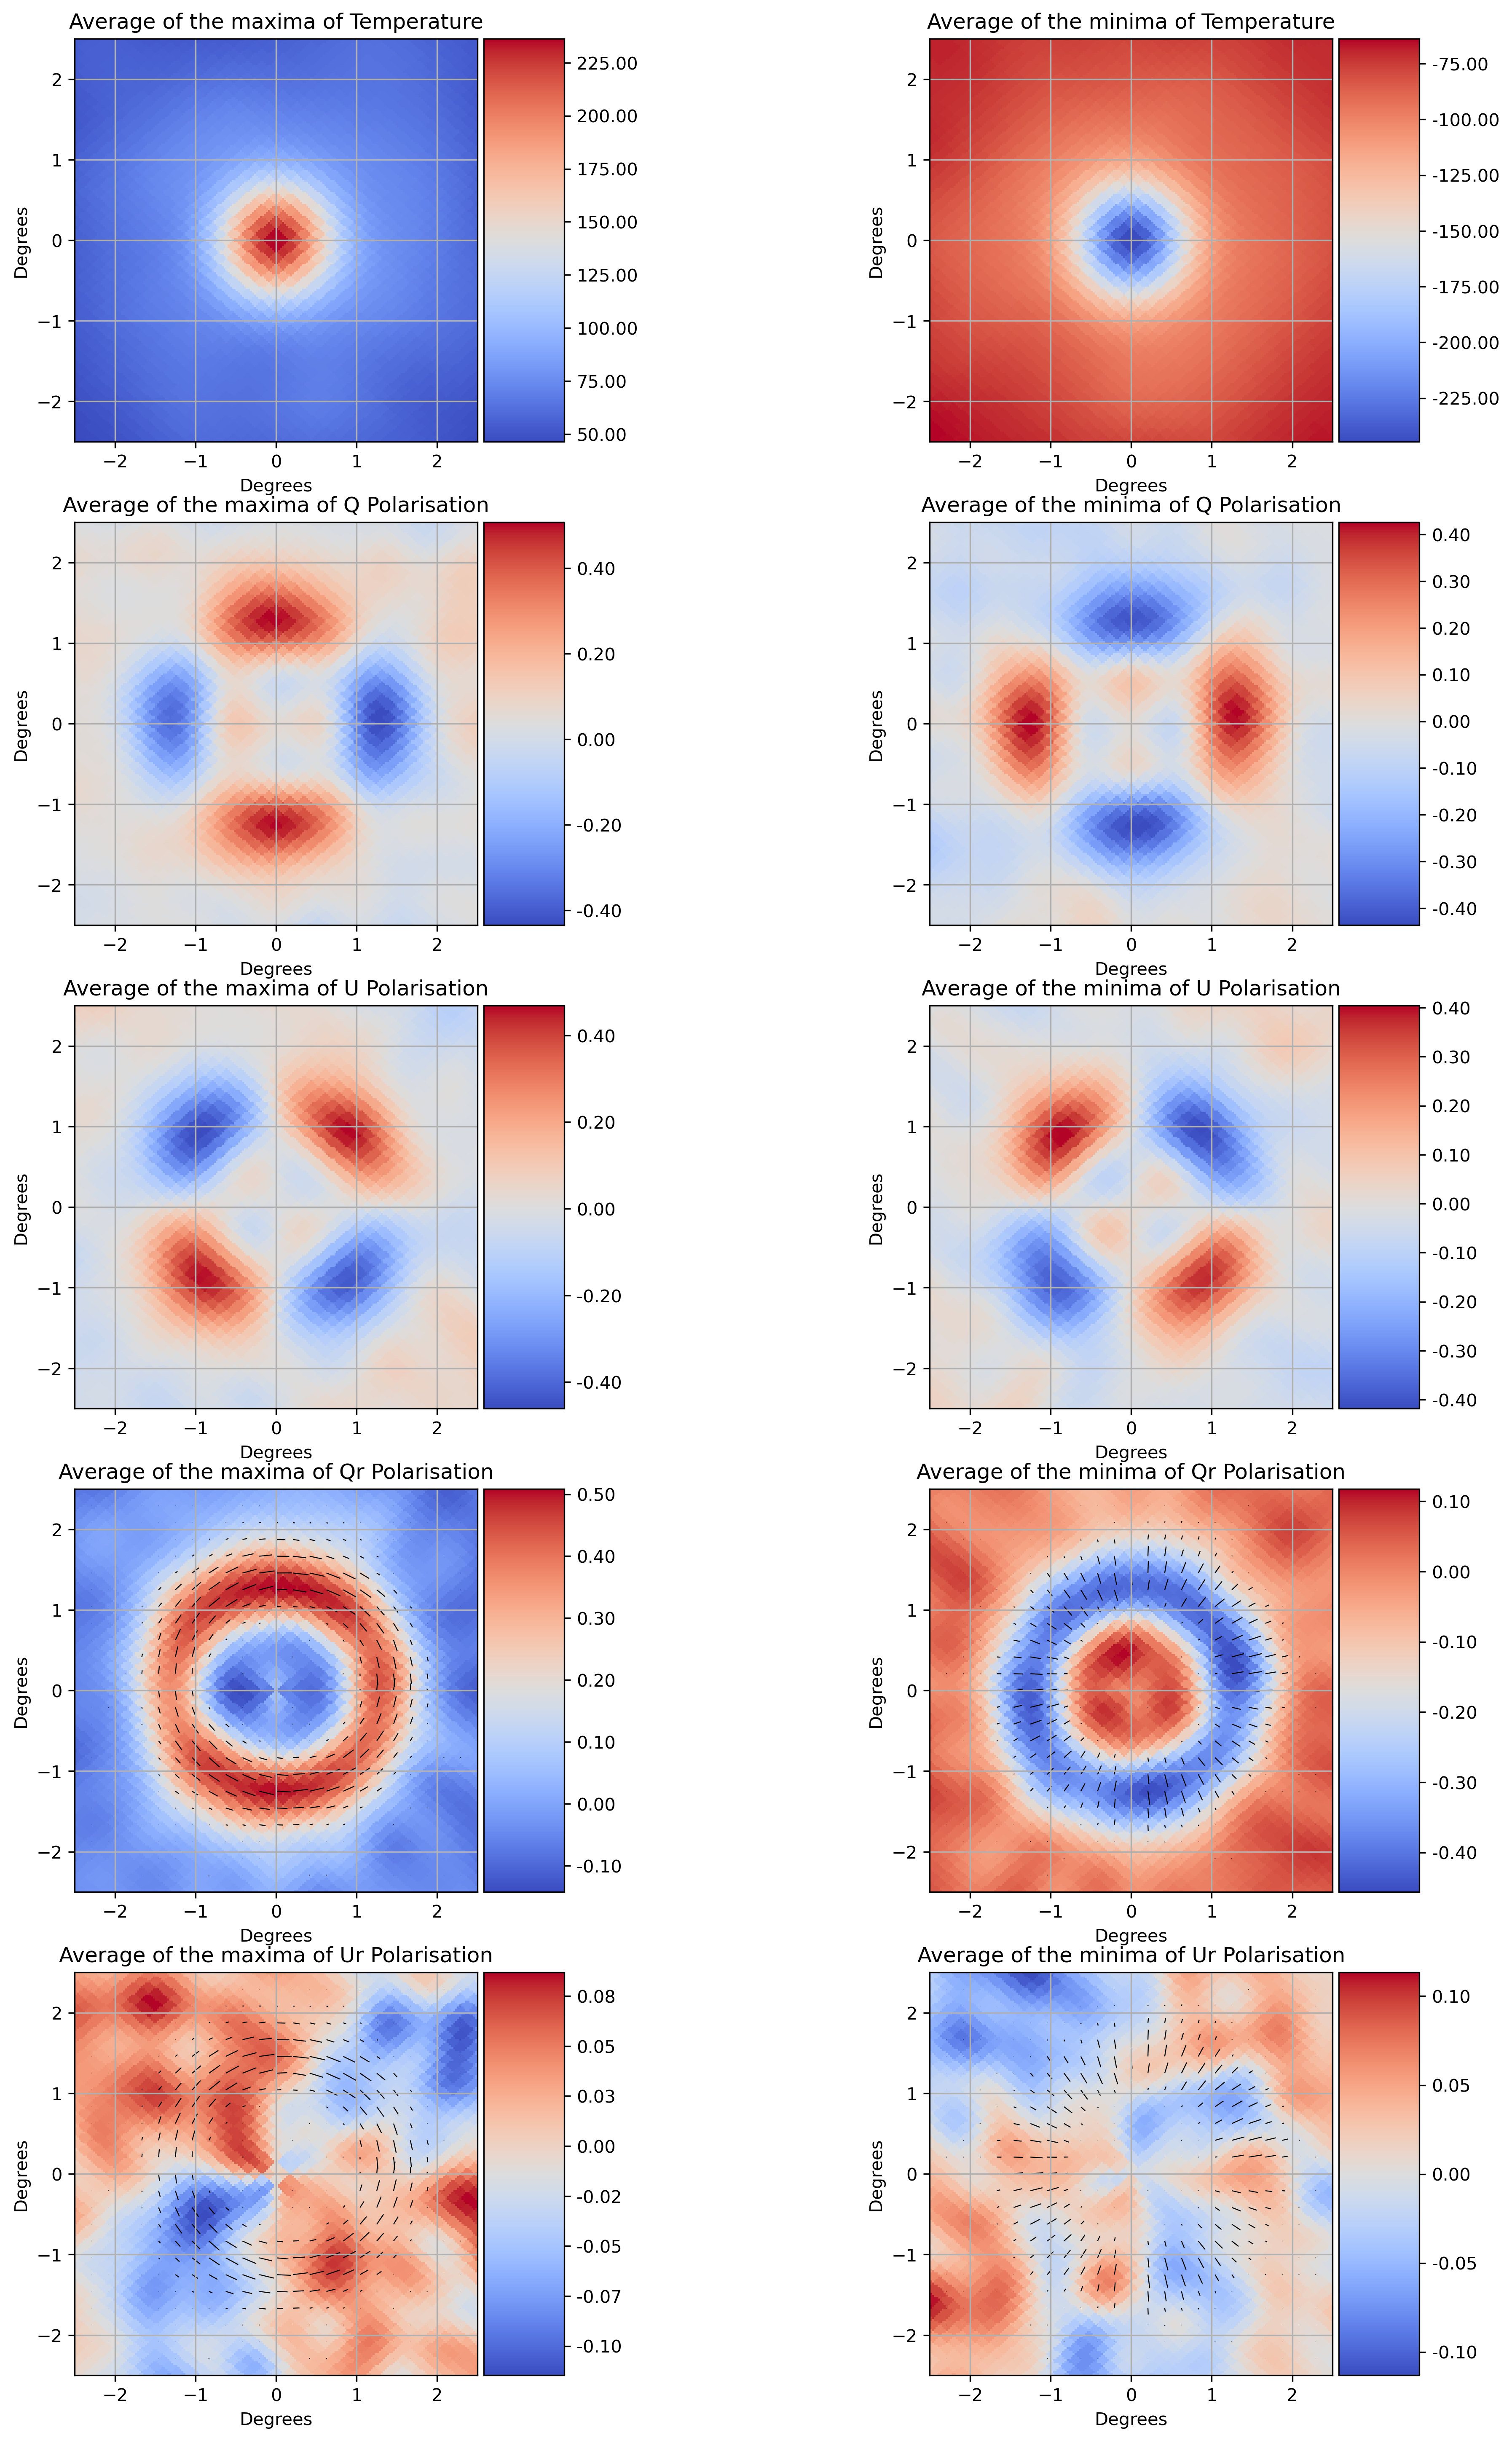

In [12]:
step = 8
x_dict, y_dict, ul_dict, vl_dict = compute_vectormaps(lensed, step)
x_dict, y_dict, un_dict, vn_dict = compute_vectormaps(nolens, step)

figl, axl = plt.subplots(5, 2, figsize=(16, 24), dpi=300)
fign, axn = plt.subplots(5, 2, figsize=(16, 24), dpi=300)

for minmax in range(2):
    for params, name in enumerate(
        [
            "Temperature",
            "Q Polarisation",
            "U Polarisation",
            "Qr Polarisation",
            "Ur Polarisation",
        ]
    ):
        quiver_required = params in [3, 4]

        plot_param(
            axn[params, minmax],
            nolens[minmax, params, :, :],
            x_dict[minmax],
            y_dict[minmax],
            un_dict[minmax] if quiver_required else None,
            vn_dict[minmax] if quiver_required else None,
            name,
            minmax,
            quiver_required,
        )

        plot_param(
            axl[params, minmax],
            lensed[minmax, params, :, :],
            x_dict[minmax],
            y_dict[minmax],
            ul_dict[minmax] if quiver_required else None,
            vl_dict[minmax] if quiver_required else None,
            name,
            minmax,
            quiver_required,
        )


figl.savefig("Output/Lensed_Average.png")
fign.savefig("Output/Nolensed_Average.png")